In [2]:
import os
import subprocess
import shutil

import pyemu
import pandas as pd
import matplotlib.pyplot as plt

from lumpyrem import run

import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

In [6]:
bins_pth = os.path.join('..', 'bins', 'win') if 'nt' in os.name else os.path.join('..', 'bins', 'linux') # Binaries
olproc_input_pth = os.path.join('..', 'data', 'olproc_input') # Measured data (field obs)

In [7]:
org_model_ws = os.path.join('..', 'temp_ml_param')
os.listdir(org_model_ws)

['pest', 'runmodel']

In [8]:
tmp_model_ws = os.path.join('..', 'temp_ml_obs')
if os.path.exists(tmp_model_ws):
    shutil.rmtree(tmp_model_ws)
shutil.copytree(org_model_ws,tmp_model_ws)
os.listdir(tmp_model_ws)

['pest', 'runmodel']

In [9]:
postproc_ws = os.path.join(tmp_model_ws, 'runmodel', 'postproc')
if not os.path.exists(postproc_ws):
    os.mkdir(postproc_ws)

In [10]:
pest_ws = os.path.join(tmp_model_ws, 'pest')

In [11]:
os.listdir(olproc_input_pth)

['dh-head-stage1.ssf',
 'obs-dts-synthetic.ssf',
 'obs-gage1.ssf',
 'obs-gage2.ssf',
 'obs-head-all.ssf',
 'obs-head-lrcalib.ssf',
 'obs-if-synthetic.ssf',
 'obs-of-synthetic.ssf',
 'obs-stage.ssf',
 'readme.md']

In [12]:
gage1_meas = pyemu.utils.smp_utils.smp_to_dataframe(os.path.join(olproc_input_pth, 'obs-gage1.ssf'))
gage2_meas = pyemu.utils.smp_utils.smp_to_dataframe(os.path.join(olproc_input_pth, 'obs-gage2.ssf'))

In [13]:
gage2_meas.head()

,datetime,name,value
0,2018-11-07,GAGE-2,7092.16
1,2018-11-08,GAGE-2,8148.60
2,2018-11-09,GAGE-2,7871.40
3,2018-11-10,GAGE-2,8011.80
4,2018-11-11,GAGE-2,9612.00


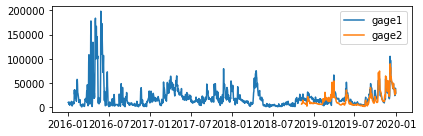

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(6,2))

x, y, = gage1_meas.datetime, gage1_meas.value
ax.plot(x, y, label='gage1')

x2, y2, = gage2_meas.datetime, gage2_meas.value
ax.plot(x2, y2, label='gage2')

plt.legend()
plt.tight_layout()

### Generate model observations for the DTS data

In [15]:
ml_ws = os.path.join(tmp_model_ws, 'runmodel', 'model')
sfr_dts_df = pd.read_csv(os.path.join(ml_ws, 'sfr_dts.obs.csv'))
sp_start = pd.to_datetime('2015-12-01') + pd.to_timedelta(sfr_dts_df.time.values,unit='d')
sfr_dts_df['datetime'] = sp_start
sfr_dts_df.drop('time', axis=1, inplace=True)
sfr_dts_df = sfr_dts_df.iloc[:3]
sfr_dts_df

,DTS_INFLOW_3,DTS_INFLOW_4,DTS_INFLOW_1,DTS_INFLOW_2,datetime
0,-31.188738,-157.031090,-16.163721,-27.355128,2015-12-02 00:00:00.000000000
1,-31.383017,-157.517797,-16.355924,-27.716971,2015-12-09 00:47:32.830195200
2,-31.845992,-158.761479,-16.478566,-28.299985,2015-12-16 01:35:05.660390400


Transform the df from wide- to long form:

In [16]:
sfr_dts_df_wide = sfr_dts_df.melt(id_vars=['datetime']) # Transform the df from wide- to long

In [17]:
# Set an artificial measured value of negative 1
sfr_dts_df_wide.value = 0.0 #-1.0

In [18]:
sfr_dts_df_wide

,datetime,variable,value
0,2015-12-02 00:00:00.000000000,DTS_INFLOW_3,0.0
1,2015-12-09 00:47:32.830195200,DTS_INFLOW_3,0.0
2,2015-12-16 01:35:05.660390400,DTS_INFLOW_3,0.0
3,2015-12-02 00:00:00.000000000,DTS_INFLOW_4,0.0
4,2015-12-09 00:47:32.830195200,DTS_INFLOW_4,0.0
5,2015-12-16 01:35:05.660390400,DTS_INFLOW_4,0.0
6,2015-12-02 00:00:00.000000000,DTS_INFLOW_1,0.0
7,2015-12-09 00:47:32.830195200,DTS_INFLOW_1,0.0
8,2015-12-16 01:35:05.660390400,DTS_INFLOW_1,0.0
9,2015-12-02 00:00:00.000000000,DTS_INFLOW_2,0.0


In [15]:
# Save the model observations to the OLPROC input directory
pyemu.utils.smp_utils.dataframe_to_smp(
    sfr_dts_df_wide,
    os.path.join(olproc_input_pth, 'obs-dts-synthetic.ssf'),
    name_col='variable',
    datetime_col='datetime',
    value_col='value',
    datetime_format='dd/mm/yyyy',
    value_format='{0:15.6E}',
    max_name_len=12
)

### Generate model observations for reach outflows

In [16]:
sfr_of_df = pd.read_csv(os.path.join(ml_ws, 'sfr_outflow_hm_1pt.obs.csv'))
sp_start = pd.to_datetime('2015-12-01') + pd.to_timedelta(sfr_of_df.time.values,unit='d')
sfr_of_df['datetime'] = sp_start
sfr_of_df.drop('time', axis=1, inplace=True)
sfr_of_df.head()

,OFH-1,OFH-2,OFH-3,OFH-4,OFH-5,OFH-6,OFH-7,OFH-8,OFH-9,OFH-10,...,OFH-123,OFH-124,OFH-125,OFH-126,OFH-127,OFH-128,OFH-129,OFH-130,OFH-131,datetime
0,-18040.78774,-17900.25939,-17661.95914,-17345.74609,-17176.34611,-17019.49716,-16719.50949,-16702.43014,-16491.81181,-16253.15177,...,-10326.00670,-10377.06474,-10443.88324,-10463.71012,-10583.09414,-10696.79548,-10819.45210,-10931.89271,-11043.21984,2015-12-02 00:00:00.000000000
1,-18044.15138,-17904.59247,-17667.88730,-17353.74367,-17185.38109,-17029.46185,-16731.28963,-16714.31831,-16504.98729,-16267.68396,...,-10401.15591,-10452.50304,-10519.59795,-10539.50353,-10659.28543,-10773.37806,-10896.57252,-11009.36506,-11121.01250,2015-12-09 00:47:32.830195200
2,-18042.55943,-17902.59078,-17665.26757,-17350.40709,-17181.73240,-17025.58380,-16727.02921,-16710.03951,-16500.56343,-16263.15312,...,-10442.87721,-10495.09886,-10563.04346,-10583.18654,-10704.17828,-10819.43253,-10944.17064,-11057.97590,-11170.54651,2015-12-16 01:35:05.660390400
3,-18040.95276,-17900.48861,-17662.31517,-17346.29482,-17177.00729,-17020.27891,-16720.54787,-16703.48533,-16493.09724,-16254.69520,...,-10357.75816,-10409.21383,-10476.42461,-10496.36220,-10616.31937,-10730.57728,-10853.98535,-10966.91071,-11078.67129,2015-12-23 02:22:38.490585600
4,-18040.81358,-17900.29952,-17662.03162,-17345.87187,-17176.50537,-17019.69483,-16719.79077,-16702.71708,-16492.17866,-16253.60937,...,-10338.78173,-10390.01054,-10456.99851,-10476.87318,-10596.50552,-10710.44756,-10833.42886,-10946.07807,-11057.59085,2015-12-30 03:10:11.320780800


In [17]:
sfr_of_df_wide = sfr_of_df.melt(id_vars=['datetime']) # Transform the df from wide- to long

In [18]:
# With "One way observations" - history matching will ensure that
# at least some flow occurs through every reach
sfr_of_df_wide.value = -3000.0 # 3000 m3/d == baseflow

In [19]:
# Save the dummy observations to the OLPROC input directory
pyemu.utils.smp_utils.dataframe_to_smp(
    sfr_of_df_wide,
    os.path.join(olproc_input_pth, 'obs-of-synthetic.ssf'),
    name_col='variable',
    datetime_col='datetime',
    value_col='value',
    datetime_format='dd/mm/yyyy',
    value_format='{0:15.6E}',
    max_name_len=12
)

In [20]:
for file in os.listdir(olproc_input_pth):
    if not 'readme' in file:
        shutil.copyfile(os.path.join(olproc_input_pth, file), os.path.join(postproc_ws, file))

In [21]:
def write_script(filename, lines):

    with open(filename, 'a') as f:
        for line in lines:
            f.write(line)
            f.write('\n')

In [22]:
write_script(os.path.join(postproc_ws, 'olproc.in'), [
'''
START GENERAL
  date_format        = dd/mm/yyyy

  # the 1st timestep is a 1-day steady state stress period
  # the subsequent transient stress period starts on 01/01/2016 
  model_start_date   = 01/12/2015
  model_start_time   = 00:00:00
  
  # MODFLOW6 time-step units are setup as day.
  model_time_units   = days

  # Set the History Matching Window
  history_match_start_date  = 01/12/2015
END GENERAL

START MEAS_SSF_FILES
  # Read the head measurements for layers 1, 2 and 3
  file = obs-head-all.ssf      group=heads   use_abs=yes  use_diff=yes
  
  # Read the stage measurements for creek Örbäcken in layer 1
  file = obs-stage.ssf     group=stage1   use_abs=yes  use_diff=yes
  
  # Read the gage 1 measurements for creek Örbäcken in layer 1
  file = obs-gage1.ssf     group=gage1   use_abs=yes  use_diff=yes
  
  # Read the gage 2 measurements for creek Örbäcken in layer 1
  file = obs-gage2.ssf     group=gage2   use_abs=yes  use_diff=yes
  
  # headstagediff is the difference between head and stage in layer 1 at the same site
  file = dh-head-stage1.ssf   group=dh_hedstg use_abs=yes use_diff=no

  # Distributed temperature sensors, synthetic dataset
  file = obs-dts-synthetic.ssf   group=>@dts use_abs=yes use_diff=no
  
  # Stream reach outflow, synthetic dataset
  file = obs-of-synthetic.ssf   group=>@of use_abs=yes use_diff=no
END MEAS_SSF_FILES

START MF6_OBS_FILES
  file = ../model/head.obs.csv
  file = ../model/sfr_stage.obs.csv
  file = ../model/sfr_gage.obs.csv
  file = ../model/sfr_dts.obs.csv
  file = ../model/sfr_outflow_hm_1pt.obs.csv
END MF6_OBS_FILES

START OUTPUT
  partial_pest_control_file = partial1.pst
  model_batch_file          = runmodel.bat
  obs_ssf_folder            = .\obs_files
END OUTPUT

START WEIGHTS
    # PERIOD OF UNRELIABLE DATA
    # Set weights for gage1 during specific period
    name = gage1 type=abs weight= 0.0 &
    date1=01/12/2015 time1 = 00:00:00 &
    date2=01/07/2016 time2 = 23:59:59
    

    # Set weights for gage1 during specific period
    name = gage1 type=diff weight= 0.0 &
    date1=01/12/2015 time1 = 00:00:00 &
    date2=01/07/2016 time2 = 23:59:59
    
    # Set weights for dts during specific period
    name = >@dts type=abs weight= 0.0 &
    date1=01/01/2016 time1 = 00:00:00 &
    date2=01/01/2020 time2 = 23:59:59
    
    name = dh_hedstg type=abs weight= 100.0
END WEIGHTS

START SECONDARY_MODEL_OUTCOMES  
  dh-ni15-O1 = "ni15-o1" - "ni15-o1-stg"
  dh-ni15-o44 = "ni15-o44" - "ni15-o44-stg"
  dh-ni15-o46 = "ni15-o46" - "ni15-o46-stg"
  dh-ni15-o47 = "ni15-o47" - "ni15-o47-stg"
  dh-ni15-o48 = "ni15-o48" - "ni15-o48-stg"
END SECONDARY_MODEL_OUTCOMES 
'''
])

In [23]:
obs_ssf_folder = os.path.join(postproc_ws, 'obs_files')
if os.path.exists(obs_ssf_folder):
    shutil.rmtree(obs_ssf_folder)
    os.mkdir(obs_ssf_folder)
else:
    os.mkdir(obs_ssf_folder)

Add a return statement to dynamically capture NOBS, NOBSGP, and NINSFILE:

In [24]:
def run_process_stdout(process, path=False, commands=[], print_output=True):
    import os
    import subprocess
    """This calls a process and then executes a list of commands.

    Parameters
    ----------
    process : str
        The name of the process to execute.
    path : str, optional
        path in which to execute commands. False (default) result sin commans being executed in current working directory.
    commands : list of str
        sequence of commands to pass to the process.
    print_output : bool, optional
            True, process output is printed. False, it is not.
        """

    if path == False:
        path = os.getcwd()

    owd = os.getcwd()
    os.chdir(path)

    p = subprocess.run([process], stdout=subprocess.PIPE,
            input='\n'.join(map(str, commands))+'\n', encoding='ascii')

    if print_output==True:
            print(p.stdout)
    os.chdir(owd)
    return p.stdout

In [25]:
# run OLPROC
olp_construct = run_process_stdout(
    'olproc',
    path=postproc_ws,
    commands=['olproc.in', 0] # Run OLPROC in postprocessor mode
)


 OLPROC Version 1.0. Watermark Numerical Computing.

 Enter name of OLPROC control file:  Enter OLPROC mode index [0 or 1]:  - file olproc.in read ok.
 - file ../model/head.obs.csv read ok.
 - file ../model/sfr_stage.obs.csv read ok.
 - file ../model/sfr_gage.obs.csv read ok.
 - file ../model/sfr_dts.obs.csv read ok.
 - file ../model/sfr_outflow_hm_1pt.obs.csv read ok.
 - file obs-head-all.ssf read ok.
 - file obs-stage.ssf read ok.
 - file obs-gage1.ssf read ok.
 - file obs-gage2.ssf read ok.
 - file dh-head-stage1.ssf read ok.
 - file obs-dts-synthetic.ssf read ok.
 - file obs-of-synthetic.ssf read ok.
 - model observation equations evaluated ok.
 - file .\obs_files\o_obs-head-all_ssf.ssf written ok.
 - file m_obs-head-all_ssf.ins written ok.
 - file m_obs-head-all_ssf.ssf written ok.
 - file .\obs_files\o_obs-stage_ssf.ssf written ok.
 - file m_obs-stage_ssf.ins written ok.
 - file m_obs-stage_ssf.ssf written ok.
 - file .\obs_files\o_obs-gage1_ssf.ssf written ok.
 - file m_obs-gag

In [26]:
nobs = olp_construct.split('\n')[-4].split()[-1]
nobsgp = olp_construct.split('\n')[-3].split()[-1]
ninsfile = olp_construct.split('\n')[-2].split()[-1]
print(nobs)
print(nobsgp)
print(ninsfile)

54270
11
11


### Create model observations of SW/GW flux (on a bound-per-bound basis)
They will carry a weight of 0 and be used for prediction purposes:

In [27]:
sfr_flux_pred_dummy = pd.read_csv(os.path.join(ml_ws, 'sfr_pred_flux.obs.csv'), index_col=0)
sfr_flux_pred_dummy.head()

,FLUX-BOUND1,FLUX-BOUND2,FLUX-BOUND3,FLUX-BOUND4,FLUX-BOUND5,FLUX-BOUND6,FLUX-BOUND7,FLUX-BOUND8,FLUX-BOUND9,FLUX-BOUND10,FLUX-BOUND11,FLUX-BOUND12,FLUX-BOUND13,FLUX-BOUND14
time,,,,,,,,,,,,,,
1.000000,3258.054674,2906.473538,3303.589733,-422.320773,-220.618622,-526.997619,-332.453004,-1168.044956,-1793.718302,-372.045139,-612.199896,-807.025156,-185.822799,-2207.633739
8.033019,3238.820658,2897.363067,3293.607931,-434.098568,-239.945440,-531.715252,-334.504583,-1171.965450,-1804.007322,-382.786305,-618.303930,-821.891715,-198.421577,-2247.551559
15.066038,3242.403267,2891.904130,3283.253282,-440.297386,-249.729941,-544.003700,-340.748391,-1182.942889,-1828.826858,-401.442303,-626.199627,-833.418204,-205.483386,-2248.327167
22.099057,3255.038917,2902.179985,3297.247218,-427.049776,-228.075689,-532.562031,-335.309877,-1173.282096,-1805.529961,-381.501224,-616.456946,-814.417420,-191.024225,-2216.407895
29.132075,3256.988046,2904.702160,3300.888720,-424.289447,-223.658888,-529.424959,-333.704627,-1170.325876,-1798.764817,-375.926982,-613.914416,-809.869949,-187.737991,-2210.453371


In [28]:
sp_start = pd.to_datetime('2015-12-01') + pd.to_timedelta(sfr_flux_pred_dummy.index.values,unit='d')

In [29]:
sfr_flux_pred_dummy.insert(0, 'datetime', sp_start)
sfr_flux_pred_dummy = sfr_flux_pred_dummy.reset_index(drop=True)
sfr_flux_pred_dummy = sfr_flux_pred_dummy.melt(id_vars=['datetime'])
sfr_flux_pred_dummy.rename(columns={'variable': 'name'}, inplace=True)

In [30]:
sfr_flux_pred_dummy.head()

,datetime,name,value
0,2015-12-02 00:00:00.000000000,FLUX-BOUND1,3258.054674
1,2015-12-09 00:47:32.830195200,FLUX-BOUND1,3238.820658
2,2015-12-16 01:35:05.660390400,FLUX-BOUND1,3242.403267
3,2015-12-23 02:22:38.490585600,FLUX-BOUND1,3255.038917
4,2015-12-30 03:10:11.320780800,FLUX-BOUND1,3256.988046


In [31]:
pyemu.utils.smp_utils.dataframe_to_smp(
    sfr_flux_pred_dummy,
    os.path.join(postproc_ws, 'pred-flux.ssf'),
    name_col='name',
    datetime_col='datetime',
    value_col='value',
    datetime_format='dd/mm/yyyy',
    value_format='{0:15.6E}',
    max_name_len=12
)

### Create model observations of bound outflow

They will carry a weight of 0 and be used for prediction purposes:

In [32]:
sfr_of_pred_dummy = pd.read_csv(os.path.join(ml_ws, 'sfr_pred_outflow.obs.csv'), index_col=0)
sfr_of_pred_dummy.head()

,OF-BOUND1,OF-BOUND2,OF-BOUND3,OF-BOUND4,OF-BOUND5,OF-BOUND6,OF-BOUND7,OF-BOUND8,OF-BOUND9,OF-BOUND10,OF-BOUND11,OF-BOUND12,OF-BOUND13,OF-BOUND14
time,,,,,,,,,,,,,,
1.000000,-265773.2476,-221977.6044,-206496.7156,-165767.9630,-298646.6372,-161302.6760,-93315.85950,-146151.1664,-358613.1014,-286589.0978,-157052.9328,-298025.4392,-232036.4442,-445502.0833
8.033019,-265967.8253,-222364.0239,-207168.8713,-166565.5688,-300586.9960,-162457.1631,-93992.64618,-147171.3582,-361000.3696,-288601.8103,-158201.8305,-300312.0028,-233964.2982,-449579.2792
15.066038,-265907.5750,-222340.0495,-207298.4357,-166834.4393,-301246.2366,-162987.0953,-94369.71219,-147838.8330,-362905.9685,-290484.0022,-159331.5416,-302555.8098,-235777.2210,-453022.7487
22.099057,-265794.2222,-222056.3819,-206701.5889,-166051.4962,-299319.7124,-161749.3137,-93602.43430,-146622.9432,-359854.7084,-287738.7533,-157729.3250,-299367.1974,-233134.0160,-447669.4842
29.132075,-265779.5212,-222005.9972,-206575.9041,-165880.2126,-298912.5663,-161480.7699,-93431.19537,-146342.5967,-359120.7381,-287059.3395,-157329.0073,-298570.4344,-232478.5732,-446363.5449


In [33]:
sp_start = pd.to_datetime('2015-12-01') + pd.to_timedelta(sfr_of_pred_dummy.index.values,unit='d')

In [34]:
sfr_of_pred_dummy.insert(0, 'datetime', sp_start)
sfr_of_pred_dummy = sfr_of_pred_dummy.reset_index(drop=True)
sfr_of_pred_dummy = sfr_of_pred_dummy.melt(id_vars=['datetime'])
sfr_of_pred_dummy.rename(columns={'variable': 'name'}, inplace=True)

In [35]:
sfr_of_pred_dummy.head()

,datetime,name,value
0,2015-12-02 00:00:00.000000000,OF-BOUND1,-265773.2476
1,2015-12-09 00:47:32.830195200,OF-BOUND1,-265967.8253
2,2015-12-16 01:35:05.660390400,OF-BOUND1,-265907.5750
3,2015-12-23 02:22:38.490585600,OF-BOUND1,-265794.2222
4,2015-12-30 03:10:11.320780800,OF-BOUND1,-265779.5212


In [36]:
pyemu.utils.smp_utils.dataframe_to_smp(
    sfr_of_pred_dummy,
    os.path.join(postproc_ws, 'pred-outflow.ssf'),
    name_col='name',
    datetime_col='datetime',
    value_col='value',
    datetime_format='dd/mm/yyyy',
    value_format='{0:15.6E}',
    max_name_len=12
)

Create model observations of SW/GW flux (on a reach-per-reach basis):

In [37]:
sfr_flux_all_dummy = pd.read_csv(os.path.join(ml_ws, 'sfr_flux_all.obs.csv'), index_col=0)
sfr_flux_all_dummy.head()

,LK-1,LK-2,LK-3,LK-4,LK-5,LK-6,LK-7,LK-8,LK-9,LK-10,...,LK-254,LK-255,LK-256,LK-257,LK-258,LK-259,LK-260,LK-261,LK-262,LK-263
time,,,,,,,,,,,,,,,,,,,,,
1.000000,506.233207,140.534935,238.312941,316.232742,169.410098,156.858817,300.010218,17.080599,210.636109,238.680202,...,-110.956734,-4.144141,-116.796790,-25.310715,-180.084540,-63.700039,-140.601956,-117.437028,-145.027295,-149.875972
8.033019,502.869470,139.565459,236.717797,314.163236,168.372644,155.929058,298.194660,16.972559,209.348719,237.323391,...,-113.695615,-4.278615,-119.477079,-26.169996,-182.721495,-64.871377,-142.864023,-119.786870,-147.423920,-152.911613
15.066038,504.440102,139.968506,237.322930,314.860037,168.674465,156.148384,298.554087,16.989672,209.475686,237.409861,...,-113.654256,-4.278469,-119.229860,-26.103236,-182.265080,-64.678946,-142.275908,-119.164842,-146.528078,-151.853783
22.099057,506.056302,140.466998,238.178930,316.028862,169.291908,156.732650,299.740792,17.063082,210.395781,238.410757,...,-111.520862,-4.173077,-117.275294,-25.472315,-180.481454,-63.884459,-140.874919,-117.724323,-145.224980,-150.164148
29.132075,506.197988,140.517708,238.274902,316.170635,169.372087,156.815991,299.916519,17.074375,210.548236,238.580431,...,-111.133312,-4.153429,-116.939318,-25.360182,-180.194006,-63.752507,-140.668431,-117.508406,-145.063072,-149.938554


In [38]:
sp_start = pd.to_datetime('2015-12-01') + pd.to_timedelta(sfr_flux_all_dummy.index.values,unit='d')

In [39]:
sfr_flux_all_dummy.insert(0, 'datetime', sp_start)
sfr_flux_all_dummy = sfr_flux_all_dummy.reset_index(drop=True)
sfr_flux_all_dummy = sfr_flux_all_dummy.melt(id_vars=['datetime'])
sfr_flux_all_dummy.rename(columns={'variable': 'name'}, inplace=True)

In [40]:
sfr_flux_all_dummy.head()

,datetime,name,value
0,2015-12-02 00:00:00.000000000,LK-1,506.233207
1,2015-12-09 00:47:32.830195200,LK-1,502.869470
2,2015-12-16 01:35:05.660390400,LK-1,504.440102
3,2015-12-23 02:22:38.490585600,LK-1,506.056302
4,2015-12-30 03:10:11.320780800,LK-1,506.197988


In [41]:
pyemu.utils.smp_utils.dataframe_to_smp(
    sfr_flux_all_dummy,
    os.path.join(postproc_ws, 'flux-all.ssf'),
    name_col='name',
    datetime_col='datetime',
    value_col='value',
    datetime_format='dd/mm/yyyy',
    value_format='{0:15.6E}',
    max_name_len=12
)

Create model observations of outflow (on a reach-per-reach basis):

In [42]:
sfr_of_all_dummy = pd.read_csv(os.path.join(ml_ws, 'sfr_outflow_all.obs.csv'), index_col=0)
sfr_of_all_dummy = sfr_of_all_dummy.iloc[:,:-1] # Do not include reach 263
sfr_of_all_dummy.head()

,OF-1,OF-2,OF-3,OF-4,OF-5,OF-6,OF-7,OF-8,OF-9,OF-10,...,OF-253,OF-254,OF-255,OF-256,OF-257,OF-258,OF-259,OF-260,OF-261,OF-262
time,,,,,,,,,,,,,,,,,,,,,
1.000000,-18040.78774,-17900.25939,-17661.95914,-17345.74609,-17176.34611,-17019.49716,-16719.50949,-16702.43014,-16491.81181,-16253.15177,...,-16677.49755,-16788.47858,-16792.62372,-16909.44238,-16934.75904,-17114.86286,-17178.57027,-17319.18683,-17436.63693,-17581.67638
8.033019,-18044.15138,-17904.59247,-17667.88730,-17353.74367,-17185.38109,-17029.46185,-16731.28963,-16714.31831,-16504.98729,-16267.68396,...,-16831.85237,-16945.57216,-16949.85177,-17069.35062,-17095.52653,-17278.26721,-17343.14592,-17486.02448,-17605.82436,-17753.26037
15.066038,-18042.55943,-17902.59078,-17665.26757,-17350.40709,-17181.73240,-17025.58380,-16727.02921,-16710.03951,-16500.56343,-16263.15312,...,-16960.74521,-17074.39892,-17078.67737,-17197.90674,-17224.00985,-17406.27450,-17470.95328,-17613.22887,-17732.39342,-17878.92123
22.099057,-18040.95276,-17900.48861,-17662.31517,-17346.29482,-17177.00729,-17020.27891,-16720.54787,-16703.48533,-16493.09724,-16254.69520,...,-16758.94292,-16870.47429,-16874.64780,-16991.93255,-17017.40744,-17197.89723,-17261.78488,-17402.66611,-17520.39609,-17665.62633
29.132075,-18040.81358,-17900.29952,-17662.03162,-17345.87187,-17176.50537,-17019.69483,-16719.79077,-16702.71708,-16492.17866,-16253.60937,...,-16709.80890,-16820.95564,-16825.10962,-16942.06102,-16967.42449,-17147.62914,-17211.38572,-17352.06222,-17469.57785,-17614.64763


In [43]:
sp_start = pd.to_datetime('2015-12-01') + pd.to_timedelta(sfr_of_all_dummy.index.values,unit='d')

In [44]:
sfr_of_all_dummy.insert(0, 'datetime', sp_start)
sfr_of_all_dummy = sfr_of_all_dummy.reset_index(drop=True)
sfr_of_all_dummy = sfr_of_all_dummy.melt(id_vars=['datetime'])
sfr_of_all_dummy.rename(columns={'variable': 'name'}, inplace=True)

In [45]:
sfr_of_all_dummy.head()

,datetime,name,value
0,2015-12-02 00:00:00.000000000,OF-1,-18040.78774
1,2015-12-09 00:47:32.830195200,OF-1,-18044.15138
2,2015-12-16 01:35:05.660390400,OF-1,-18042.55943
3,2015-12-23 02:22:38.490585600,OF-1,-18040.95276
4,2015-12-30 03:10:11.320780800,OF-1,-18040.81358


In [46]:
pyemu.utils.smp_utils.dataframe_to_smp(
    sfr_of_all_dummy,
    os.path.join(postproc_ws, 'of-all.ssf'),
    name_col='name',
    datetime_col='datetime',
    value_col='value',
    datetime_format='dd/mm/yyyy',
    value_format='{0:15.6E}',
    max_name_len=12
)

In [47]:
write_script(os.path.join(postproc_ws, 'olproc-pred.in'), [
'''
START GENERAL
  date_format        = dd/mm/yyyy

  # the 1st timestep is a 1-day steady state stress period
  # the subsequent transient stress period starts on 01/01/2016 
  model_start_date   = 01/12/2015
  model_start_time   = 00:00:00
  
  # MODFLOW6 time-step units are setup as day.
  model_time_units   = days

  # Set the History Matching Window
  history_match_start_date  = 01/12/2015
END GENERAL

START MEAS_SSF_FILES
  file = pred-flux.ssf  group=pfluxb use_abs=yes use_diff=no
  file = pred-outflow.ssf  group=pofb use_abs=yes use_diff=no
  file = flux-all.ssf  group=pfluxr use_abs=yes use_diff=no
  file = of-all.ssf  group=pofr use_abs=yes use_diff=no
END MEAS_SSF_FILES

START MF6_OBS_FILES
  file = ../model/sfr_pred_flux.obs.csv
  file = ../model/sfr_pred_outflow.obs.csv
  file = ../model/sfr_flux_1pt.obs.csv
  file = ../model/sfr_flux_2pt.obs.csv
  file = ../model/sfr_outflow_1pt.obs.csv
  file = ../model/sfr_outflow_2pt.obs.csv
END MF6_OBS_FILES

START OUTPUT
  partial_pest_control_file = partial2.pst
  model_batch_file          = runmodel.bat
  obs_ssf_folder            = .\obs_files
END OUTPUT

START WEIGHTS              
  name = pfluxb type=abs weight=0
  name = pofb type=abs weight=0
  name = pfluxr type=abs weight=0
  name = pofr type=abs weight=0
END WEIGHTS

'''
])

In [48]:
# run OLPROC
olp_pred_construct = run_process_stdout(
    'olproc',
    path=postproc_ws,
    commands=['olproc-pred.in', 0] # Run OLPROC in postprocessor mode
)


 OLPROC Version 1.0. Watermark Numerical Computing.

 Enter name of OLPROC control file:  Enter OLPROC mode index [0 or 1]:  - file olproc-pred.in read ok.
 - file ../model/sfr_pred_flux.obs.csv read ok.
 - file ../model/sfr_pred_outflow.obs.csv read ok.
 - file ../model/sfr_flux_1pt.obs.csv read ok.
 - file ../model/sfr_flux_2pt.obs.csv read ok.
 - file ../model/sfr_outflow_1pt.obs.csv read ok.
 - file ../model/sfr_outflow_2pt.obs.csv read ok.
 - file pred-flux.ssf read ok.
 - file pred-outflow.ssf read ok.
 - file flux-all.ssf read ok.
 - file of-all.ssf read ok.
 - file .\obs_files\o_pred-flux_ssf.ssf written ok.
 - file m_pred-flux_ssf.ins written ok.
 - file m_pred-flux_ssf.ssf written ok.
 - file .\obs_files\o_pred-outflow_ssf.ssf written ok.
 - file m_pred-outflow_ssf.ins written ok.
 - file m_pred-outflow_ssf.ssf written ok.
 - file .\obs_files\o_flux-all_ssf.ssf written ok.
 - file m_flux-all_ssf.ins written ok.
 - file m_flux-all_ssf.ssf written ok.
 - file .\obs_files\o_of-

In [49]:
nobs_pred = olp_pred_construct.split('\n')[-4].split()[-1]
nobsgp_pred = olp_pred_construct.split('\n')[-3].split()[-1]
ninsfile_pred = olp_pred_construct.split('\n')[-2].split()[-1]
print(nobs_pred)
print(nobsgp_pred)
print(ninsfile_pred)

117789
4
4


Add obs, obsgp and ninsfile from both the history-matching dataset and the prediction datasets:

In [50]:
nobs_tot = int(nobs) + int(nobs_pred)
nobsgp_tot = int(nobsgp) + int(nobsgp_pred)
ninsfile_tot = int(ninsfile) + int(ninsfile_pred)
print(nobs_tot)
print(nobsgp_tot)
print(ninsfile_tot)

172059
15
15


Copy all the instruction files to the pest\instruction folder:

In [51]:
insfiles = [i for i in os.listdir(postproc_ws) if '.ins' in i]

In [52]:
instruction_ws = os.path.join(tmp_model_ws, 'pest', 'instruction')

In [53]:
for file in insfiles:
    shutil.copyfile(os.path.join(postproc_ws, file), os.path.join(instruction_ws, file))

### Concatenate pestfiles

In [54]:
with open(os.path.join(pest_ws, 'calib0.pst'), 'r') as file:
    calib0_pstfile = file.readlines()

In [55]:
display(calib0_pstfile)

['pcf\n',
 '* control data\n',
 'restart estimation\n',
 '1709 0 26 0 0\n',
 '   13  0    single  point\n',
 ' 10.0  -3.0  0.3  0.03  10  lamforgive\n',
 ' 10.0  10.0  0.001\n',
 ' 0.1\n',
 ' 50  0.005  4  4  0.005  4\n',
 ' 0  0  0\n',
 '* singular value decomposition\n',
 '1\n',
 '  5000  5e-7\n',
 '0\n',
 '* parameter groups\n',
 'ghbcbl relative 0.015 0.0 switch 2 parabolic\n',
 'ghbcgr relative 0.015 0.0 switch 2 parabolic\n',
 'ghbcre relative 0.015 0.0 switch 2 parabolic\n',
 'ghbcye relative 0.015 0.0 switch 2 parabolic\n',
 'ghbmul relative 0.015 0.0 switch 2 parabolic\n',
 'khpp relative 0.015 0.0 switch 2 parabolic\n',
 'lr_cf relative 0.015 0.0 switch 2 parabolic\n',
 'lr_f1 relative 0.015 0.0 switch 2 parabolic\n',
 'lr_f2 relative 0.015 0.0 switch 2 parabolic\n',
 'lr_gam relative 0.015 0.0 switch 2 parabolic\n',
 'lr_ks relative 0.015 0.0 switch 2 parabolic\n',
 'lr_m relative 0.015 0.0 switch 2 parabolic\n',
 'lr_off relative 0.015 0.0 switch 2 parabolic\n',
 'lr_pow re

In [56]:
with open(os.path.join(postproc_ws, 'partial1.pst'), 'r') as file:
    partial_pstfile_obs1 = file.readlines()

In [57]:
display(partial_pstfile_obs1)

['* observation groups\n',
 'heads\n',
 'stage1\n',
 'gage1\n',
 'gage2\n',
 'dh_hedstg\n',
 '>@dts\n',
 '>@of\n',
 'heads_d\n',
 'stage1_d\n',
 'gage1_d\n',
 'gage2_d\n',
 '* observation data\n',
 ' b10-1_1                133.695000            1.000000          heads\n',
 ' b10-1_2                133.620000            1.000000          heads\n',
 ' b10-1_3                133.480000            1.000000          heads\n',
 ' b10-1_4                133.425000            1.000000          heads\n',
 ' b14-1_1                140.200000            1.000000          heads\n',
 ' b14-1_2                139.900000            1.000000          heads\n',
 ' b14-1_3                139.880000            1.000000          heads\n',
 ' b15-1_1                141.204000            1.000000          heads\n',
 ' b15-1_2                140.940000            1.000000          heads\n',
 ' b15-1_3                140.940000            1.000000          heads\n',
 ' b16-1_1                138.081000       

In [58]:
ppf_obs_ogp_strt = partial_pstfile_obs1.index('* observation groups\n') + 1
ppf_obs_ogp_stop = partial_pstfile_obs1.index('* observation data\n')

In [59]:
ppf_obs_ogp1 = partial_pstfile_obs1[ppf_obs_ogp_strt:ppf_obs_ogp_stop] #partial pestfile obsgrp
display(ppf_obs_ogp1)

['heads\n',
 'stage1\n',
 'gage1\n',
 'gage2\n',
 'dh_hedstg\n',
 '>@dts\n',
 '>@of\n',
 'heads_d\n',
 'stage1_d\n',
 'gage1_d\n',
 'gage2_d\n']

make temp copy of `calib0.pst`:

In [60]:
calib0_pstfile_temp = calib0_pstfile[:]

In [61]:
calib0_calib_ogp_strt = calib0_pstfile_temp.index('* observation groups\n') + 1
calib0_calib_ogp_stop = calib0_pstfile_temp.index('* observation data\n')

In [62]:
calib0_pstfile_temp

['pcf\n',
 '* control data\n',
 'restart estimation\n',
 '1709 0 26 0 0\n',
 '   13  0    single  point\n',
 ' 10.0  -3.0  0.3  0.03  10  lamforgive\n',
 ' 10.0  10.0  0.001\n',
 ' 0.1\n',
 ' 50  0.005  4  4  0.005  4\n',
 ' 0  0  0\n',
 '* singular value decomposition\n',
 '1\n',
 '  5000  5e-7\n',
 '0\n',
 '* parameter groups\n',
 'ghbcbl relative 0.015 0.0 switch 2 parabolic\n',
 'ghbcgr relative 0.015 0.0 switch 2 parabolic\n',
 'ghbcre relative 0.015 0.0 switch 2 parabolic\n',
 'ghbcye relative 0.015 0.0 switch 2 parabolic\n',
 'ghbmul relative 0.015 0.0 switch 2 parabolic\n',
 'khpp relative 0.015 0.0 switch 2 parabolic\n',
 'lr_cf relative 0.015 0.0 switch 2 parabolic\n',
 'lr_f1 relative 0.015 0.0 switch 2 parabolic\n',
 'lr_f2 relative 0.015 0.0 switch 2 parabolic\n',
 'lr_gam relative 0.015 0.0 switch 2 parabolic\n',
 'lr_ks relative 0.015 0.0 switch 2 parabolic\n',
 'lr_m relative 0.015 0.0 switch 2 parabolic\n',
 'lr_off relative 0.015 0.0 switch 2 parabolic\n',
 'lr_pow re

In [63]:
calib0_pstfile_temp[calib0_calib_ogp_strt:calib0_calib_ogp_stop] = ppf_obs_ogp1

obsgroups are now inserted at the correct location:

In [64]:
calib0_pstfile_temp[-30:]

['sypp220 log factor 0.2500000 1.0000000E-02 0.4000000 sypp 1.0 0.0\n',
 'sypp221 log factor 0.2500000 1.0000000E-02 0.4000000 sypp 1.0 0.0\n',
 '* observation groups\n',
 'heads\n',
 'stage1\n',
 'gage1\n',
 'gage2\n',
 'dh_hedstg\n',
 '>@dts\n',
 '>@of\n',
 'heads_d\n',
 'stage1_d\n',
 'gage1_d\n',
 'gage2_d\n',
 '* observation data\n',
 '* model command line\n',
 '* model input/output\n',
 '.\\template\\pps_cond.tpl ..\\runmodel\\preproc\\pps_cond.dat\n',
 '.\\template\\pps_sy_rchmul.tpl ..\\runmodel\\preproc\\pps_sy_rchmul.dat\n',
 '.\\template\\pps_sfr.tpl ..\\runmodel\\preproc\\pps_sfr.dat\n',
 '.\\template\\pps_ghb.tpl ..\\runmodel\\preproc\\pps_ghb.dat\n',
 '.\\template\\ghb_multiplier.tpl ..\\runmodel\\preproc\\ghb_multiplier.py\n',
 '.\\template\\sfr_rainf_evapo_multiplier.tpl ..\\runmodel\\preproc\\sfr_rainf_evapo_multiplier.py\n',
 '.\\template\\sfr_rtpmodel.tpl ..\\runmodel\\preproc\\sfr_rtpmodel.py\n',
 '.\\template\\sfr_reach1_inflow.tpl ..\\runmodel\\model\\sfr_reach1_i

Moving on to obsdata (calibration dataset):

In [65]:
ppf1_obs_odt_strt = partial_pstfile_obs1.index('* observation data\n') + 1
ppf1_obs_odt_stop = partial_pstfile_obs1.index('* model command line\n')

In [66]:
ppf1_obs_odt = partial_pstfile_obs1[ppf1_obs_odt_strt:ppf1_obs_odt_stop]

In [67]:
ppf1_calib_odt_strt = calib0_pstfile_temp.index('* observation data\n') + 1
ppf1_calib_odt_stop = calib0_pstfile_temp.index('* model command line\n')

In [68]:
#calib0_pstfile_temp.insert(calib0_pstfile_temp.index('* observation data\n') + 1, ppf1_obs_odt[0])

In [69]:
calib0_pstfile_temp[ppf1_calib_odt_strt:ppf1_calib_odt_stop] = ppf1_obs_odt

In [70]:
calib0_pstfile_temp[-30:]

[' gage-2_d407            38660.2400            100.0000          gage2_d\n',
 ' gage-2_d408            32801.2400            100.0000          gage2_d\n',
 ' gage-2_d409            37450.6400            100.0000          gage2_d\n',
 ' gage-2_d410            38806.0400            100.0000          gage2_d\n',
 ' gage-2_d411            42805.6400            100.0000          gage2_d\n',
 ' gage-2_d412            36813.4400            100.0000          gage2_d\n',
 ' gage-2_d413            31175.8400            100.0000          gage2_d\n',
 ' gage-2_d414            31242.4400            100.0000          gage2_d\n',
 ' gage-2_d415            27905.2400            100.0000          gage2_d\n',
 ' gage-2_d416            23313.4400            100.0000          gage2_d\n',
 ' gage-2_d417            19029.4400            100.0000          gage2_d\n',
 ' gage-2_d418            20350.6400            100.0000          gage2_d\n',
 ' gage-2_d419            28432.6400            100.0000        

In [71]:
calib0_pstfile_temp[calib0_pstfile_temp.index('* observation data\n'):]

['* observation data\n',
 ' b10-1_1                133.695000            1.000000          heads\n',
 ' b10-1_2                133.620000            1.000000          heads\n',
 ' b10-1_3                133.480000            1.000000          heads\n',
 ' b10-1_4                133.425000            1.000000          heads\n',
 ' b14-1_1                140.200000            1.000000          heads\n',
 ' b14-1_2                139.900000            1.000000          heads\n',
 ' b14-1_3                139.880000            1.000000          heads\n',
 ' b15-1_1                141.204000            1.000000          heads\n',
 ' b15-1_2                140.940000            1.000000          heads\n',
 ' b15-1_3                140.940000            1.000000          heads\n',
 ' b16-1_1                138.081000            1.000000          heads\n',
 ' b16-1_2                137.870000            1.000000          heads\n',
 ' b16-1_3                137.820000            1.000000       

Obsgrp (prediction dataset):

In [72]:
with open(os.path.join(postproc_ws, 'partial2.pst'), 'r') as file:
    partial_pstfile_obs2 = file.readlines()

In [73]:
ppf2_obs_ogp_strt = partial_pstfile_obs2.index('* observation groups\n') + 1
ppf2_obs_ogp_stop = partial_pstfile_obs2.index('* observation data\n')

In [74]:
ppf2_obs_ogp = partial_pstfile_obs2[ppf2_obs_ogp_strt:ppf2_obs_ogp_stop]

In [75]:
ppf2_obs_ogp

['pfluxb\n', 'pofb\n', 'pfluxr\n', 'pofr\n']

Insert at last position of observation groups (which is one position above * observation data):

In [76]:
calib0_pstfile_temp.insert(calib0_pstfile_temp.index('* observation data\n'), ppf2_obs_ogp[0])

In [77]:
calib0_pstfile_temp.insert(calib0_pstfile_temp.index('* observation data\n'), ppf2_obs_ogp[1])
calib0_pstfile_temp.insert(calib0_pstfile_temp.index('* observation data\n'), ppf2_obs_ogp[2])
calib0_pstfile_temp.insert(calib0_pstfile_temp.index('* observation data\n'), ppf2_obs_ogp[3])

In [78]:
calib0_pstfile_temp[calib0_pstfile_temp.index('* observation data\n')-30:]

['sypp208 log factor 0.2500000 1.0000000E-02 0.4000000 sypp 1.0 0.0\n',
 'sypp209 log factor 0.2500000 1.0000000E-02 0.4000000 sypp 1.0 0.0\n',
 'sypp210 log factor 0.2500000 1.0000000E-02 0.4000000 sypp 1.0 0.0\n',
 'sypp211 log factor 0.2500000 1.0000000E-02 0.4000000 sypp 1.0 0.0\n',
 'sypp212 log factor 0.2500000 1.0000000E-02 0.4000000 sypp 1.0 0.0\n',
 'sypp213 log factor 0.2500000 1.0000000E-02 0.4000000 sypp 1.0 0.0\n',
 'sypp214 log factor 0.2500000 1.0000000E-02 0.4000000 sypp 1.0 0.0\n',
 'sypp215 log factor 0.2500000 1.0000000E-02 0.4000000 sypp 1.0 0.0\n',
 'sypp216 log factor 0.2500000 1.0000000E-02 0.4000000 sypp 1.0 0.0\n',
 'sypp217 log factor 0.2500000 1.0000000E-02 0.4000000 sypp 1.0 0.0\n',
 'sypp218 log factor 0.2500000 1.0000000E-02 0.4000000 sypp 1.0 0.0\n',
 'sypp219 log factor 0.2500000 1.0000000E-02 0.4000000 sypp 1.0 0.0\n',
 'sypp220 log factor 0.2500000 1.0000000E-02 0.4000000 sypp 1.0 0.0\n',
 'sypp221 log factor 0.2500000 1.0000000E-02 0.4000000 sypp 1.0 

Obsdata (prediction dataset):

In [79]:
ppf2_obs_odt_strt = partial_pstfile_obs2.index('* observation data\n') + 1
ppf2_obs_odt_stop = partial_pstfile_obs2.index('* model command line\n')

In [80]:
ppf2_obs_odt = partial_pstfile_obs2[ppf2_obs_odt_strt:ppf2_obs_odt_stop]

In [81]:
ppf2_obs_odt

[' flux-bound1_1          3258.05500            0.000000          pfluxb\n',
 ' flux-bound1_2          3238.82100            0.000000          pfluxb\n',
 ' flux-bound1_3          3242.40300            0.000000          pfluxb\n',
 ' flux-bound1_4          3255.03900            0.000000          pfluxb\n',
 ' flux-bound1_5          3256.98800            0.000000          pfluxb\n',
 ' flux-bound1_6          3259.12000            0.000000          pfluxb\n',
 ' flux-bound1_7          3259.39800            0.000000          pfluxb\n',
 ' flux-bound1_8          3262.42800            0.000000          pfluxb\n',
 ' flux-bound1_9          3269.75700            0.000000          pfluxb\n',
 ' flux-bound1_10         3261.94800            0.000000          pfluxb\n',
 ' flux-bound1_11         3246.92700            0.000000          pfluxb\n',
 ' flux-bound1_12         3247.36900            0.000000          pfluxb\n',
 ' flux-bound1_13         3253.98100            0.000000          pfluxb\n',

Insert at last position of observation data (which is one position above * model command line):

In [82]:
lastrow = calib0_pstfile_temp.index('* model command line\n')

In [83]:
calib0_pstfile_temp[lastrow:lastrow] = ppf2_obs_odt

In [84]:
calib0_pstfile_temp[-50:]

[' of-262_179             -16980.0100           0.000000          pofr\n',
 ' of-262_180             -16951.8500           0.000000          pofr\n',
 ' of-262_181             -16911.5200           0.000000          pofr\n',
 ' of-262_182             -17080.4800           0.000000          pofr\n',
 ' of-262_183             -17409.9100           0.000000          pofr\n',
 ' of-262_184             -17545.0300           0.000000          pofr\n',
 ' of-262_185             -17375.8700           0.000000          pofr\n',
 ' of-262_186             -17214.0400           0.000000          pofr\n',
 ' of-262_187             -17043.3400           0.000000          pofr\n',
 ' of-262_188             -16949.0400           0.000000          pofr\n',
 ' of-262_189             -16995.9800           0.000000          pofr\n',
 ' of-262_190             -17026.3500           0.000000          pofr\n',
 ' of-262_191             -16915.3500           0.000000          pofr\n',
 ' of-262_192            

### Update relative path names for each of the instruction and model output files

In [85]:
ml_io_start1 = partial_pstfile_obs1.index('* model input/output\n') + 2

In [86]:
prepend1, prepend2 = '.\\instruction\\', '..\\runmodel\\postproc\\'

In [87]:
new_ml_io1 = []
for i in partial_pstfile_obs1[ml_io_start1:]:
    for string, j in zip([prepend1, prepend2], i.split()):
        new_ml_io1.append(string + j)

In [88]:
new_ml_io1 = [' '.join(i) for i in zip(new_ml_io1[0::2], new_ml_io1[1::2])]

In [89]:
new_ml_io1 = [i+'\n' for i in new_ml_io1]

In [90]:
new_ml_io1

['.\\instruction\\m_obs-head-all_ssf.ins ..\\runmodel\\postproc\\m_obs-head-all_ssf.ssf\n',
 '.\\instruction\\m_obs-stage_ssf.ins ..\\runmodel\\postproc\\m_obs-stage_ssf.ssf\n',
 '.\\instruction\\m_obs-gage1_ssf.ins ..\\runmodel\\postproc\\m_obs-gage1_ssf.ssf\n',
 '.\\instruction\\m_obs-gage2_ssf.ins ..\\runmodel\\postproc\\m_obs-gage2_ssf.ssf\n',
 '.\\instruction\\m_dh-head-stage1_ssf.ins ..\\runmodel\\postproc\\m_dh-head-stage1_ssf.ssf\n',
 '.\\instruction\\m_obs-dts-synthetic_ssf.ins ..\\runmodel\\postproc\\m_obs-dts-synthetic_ssf.ssf\n',
 '.\\instruction\\m_obs-of-synthetic_ssf.ins ..\\runmodel\\postproc\\m_obs-of-synthetic_ssf.ssf\n',
 '.\\instruction\\m_obs-head-all_ssf_d.ins ..\\runmodel\\postproc\\m_obs-head-all_ssf_d.ssf\n',
 '.\\instruction\\m_obs-stage_ssf_d.ins ..\\runmodel\\postproc\\m_obs-stage_ssf_d.ssf\n',
 '.\\instruction\\m_obs-gage1_ssf_d.ins ..\\runmodel\\postproc\\m_obs-gage1_ssf_d.ssf\n',
 '.\\instruction\\m_obs-gage2_ssf_d.ins ..\\runmodel\\postproc\\m_obs-gage2_

In [91]:
ml_io_start2 = partial_pstfile_obs2.index('* model input/output\n') + 2

In [92]:
new_ml_io2 = []
for i in partial_pstfile_obs2[ml_io_start2:]:
    for string, j in zip([prepend1, prepend2], i.split()):
        new_ml_io2.append(string + j)

In [93]:
new_ml_io2

['.\\instruction\\m_pred-flux_ssf.ins',
 '..\\runmodel\\postproc\\m_pred-flux_ssf.ssf',
 '.\\instruction\\m_pred-outflow_ssf.ins',
 '..\\runmodel\\postproc\\m_pred-outflow_ssf.ssf',
 '.\\instruction\\m_flux-all_ssf.ins',
 '..\\runmodel\\postproc\\m_flux-all_ssf.ssf',
 '.\\instruction\\m_of-all_ssf.ins',
 '..\\runmodel\\postproc\\m_of-all_ssf.ssf']

In [94]:
new_ml_io2 = [' '.join(i) for i in zip(new_ml_io2[0::2], new_ml_io2[1::2])]

In [95]:
new_ml_io2 = [i+'\n' for i in new_ml_io2]

In [96]:
new_ml_io2

['.\\instruction\\m_pred-flux_ssf.ins ..\\runmodel\\postproc\\m_pred-flux_ssf.ssf\n',
 '.\\instruction\\m_pred-outflow_ssf.ins ..\\runmodel\\postproc\\m_pred-outflow_ssf.ssf\n',
 '.\\instruction\\m_flux-all_ssf.ins ..\\runmodel\\postproc\\m_flux-all_ssf.ssf\n',
 '.\\instruction\\m_of-all_ssf.ins ..\\runmodel\\postproc\\m_of-all_ssf.ssf\n']

In [97]:
calib0_pstfile_temp = calib0_pstfile_temp + new_ml_io1 + new_ml_io2

In [98]:
calib0_pstfile_temp[-50:]

[' of-262_194             -16930.5100           0.000000          pofr\n',
 ' of-262_195             -17087.9500           0.000000          pofr\n',
 ' of-262_196             -17087.0800           0.000000          pofr\n',
 ' of-262_197             -17268.6300           0.000000          pofr\n',
 ' of-262_198             -17524.5700           0.000000          pofr\n',
 ' of-262_199             -17588.5900           0.000000          pofr\n',
 ' of-262_200             -17450.6500           0.000000          pofr\n',
 ' of-262_201             -17420.1200           0.000000          pofr\n',
 ' of-262_202             -17409.6600           0.000000          pofr\n',
 ' of-262_203             -17617.6300           0.000000          pofr\n',
 ' of-262_204             -17922.0100           0.000000          pofr\n',
 ' of-262_205             -17623.0200           0.000000          pofr\n',
 ' of-262_206             -17437.6700           0.000000          pofr\n',
 ' of-262_207            

### Change NOBS, NOBSGP, NINSFLE

In [99]:
calib0_pstfile_temp

['pcf\n',
 '* control data\n',
 'restart estimation\n',
 '1709 0 26 0 0\n',
 '   13  0    single  point\n',
 ' 10.0  -3.0  0.3  0.03  10  lamforgive\n',
 ' 10.0  10.0  0.001\n',
 ' 0.1\n',
 ' 50  0.005  4  4  0.005  4\n',
 ' 0  0  0\n',
 '* singular value decomposition\n',
 '1\n',
 '  5000  5e-7\n',
 '0\n',
 '* parameter groups\n',
 'ghbcbl relative 0.015 0.0 switch 2 parabolic\n',
 'ghbcgr relative 0.015 0.0 switch 2 parabolic\n',
 'ghbcre relative 0.015 0.0 switch 2 parabolic\n',
 'ghbcye relative 0.015 0.0 switch 2 parabolic\n',
 'ghbmul relative 0.015 0.0 switch 2 parabolic\n',
 'khpp relative 0.015 0.0 switch 2 parabolic\n',
 'lr_cf relative 0.015 0.0 switch 2 parabolic\n',
 'lr_f1 relative 0.015 0.0 switch 2 parabolic\n',
 'lr_f2 relative 0.015 0.0 switch 2 parabolic\n',
 'lr_gam relative 0.015 0.0 switch 2 parabolic\n',
 'lr_ks relative 0.015 0.0 switch 2 parabolic\n',
 'lr_m relative 0.015 0.0 switch 2 parabolic\n',
 'lr_off relative 0.015 0.0 switch 2 parabolic\n',
 'lr_pow re

In [100]:
calib0_pstfile_temp[3]

'1709 0 26 0 0\n'

In [101]:
temp_row = calib0_pstfile_temp[3].split()
display(temp_row)

['1709', '0', '26', '0', '0']

In [102]:
temp_row[1] = str(nobs_tot)
temp_row[-1] = f'{nobsgp_tot}\n'
display(temp_row)

['1709', '172059', '26', '0', '15\n']

In [103]:
new_row = ' '.join(temp_row)
display(new_row)

'1709 172059 26 0 15\n'

In [104]:
calib0_pstfile_temp[3] = new_row

In [105]:
temp_row = calib0_pstfile_temp[4].split()
display(temp_row)

['13', '0', 'single', 'point']

In [106]:
temp_row[1] = str(ninsfile_tot)
temp_row[-1] = f'{temp_row[-1]}\n'
display(temp_row)

['13', '15', 'single', 'point\n']

In [107]:
new_row = ' '.join(temp_row)
display(new_row)

'13 15 single point\n'

In [108]:
calib0_pstfile_temp[4] = new_row

In [109]:
calib0_pstfile_temp[:10]

['pcf\n',
 '* control data\n',
 'restart estimation\n',
 '1709 172059 26 0 15\n',
 '13 15 single point\n',
 ' 10.0  -3.0  0.3  0.03  10  lamforgive\n',
 ' 10.0  10.0  0.001\n',
 ' 0.1\n',
 ' 50  0.005  4  4  0.005  4\n',
 ' 0  0  0\n']

In [110]:
### Write new pestfile

In [111]:
with open(os.path.join(pest_ws, 'calib0.pst'), 'w') as file:
    for line in calib0_pstfile_temp:
        file.write(line)

In [112]:
# Errors pertaining to missing model command line is irrelevant.
# This will be adressed in the next notebook.
p = subprocess.run(['i64pestchek', 'calib0.pst'], cwd=pest_ws, stdout=subprocess.PIPE, text=True)
for row in p.stdout.split('\n'):
    print(row)

 PESTCHEK Version 17.3. Watermark Numerical Computing.

 Errors ----->
 Line 173829 of file calib0.pst: missing model command line (1 expected).



## END OF NOTEBOOK

---